In [1]:
# For Google Colab use commands installing packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Install Pennylane and Pylatexenc in Google Colab
if IN_COLAB:
  !pip install pennylane pennylane-qiskit
  !pip install pylatexenc #for using MPL

# **2024-01-18** N-Queens with VQA

## 1 Idea

## 2 Code

In [2]:
import pennylane as qml
import numpy as np
import torch
from torch import optim
from collections import defaultdict
import networkx as nx
import copy
import math
from itertools import combinations
import sys

### Functions

### Using Chess Class

In [3]:
class Chess:
  def __init__(self, size = 4, horses = []):
    '''
      Args :
        size(int) : size of Chess Board
        horses(list[list[int]]) : indexes(row, col) of placed horses, Not Duplicated with Same Row or Column
    '''
    is_nonempty = defaultdict(int)
    self.board = [[0 for _ in range(size)] for _ in range(size)]
    self.horses = horses
    self.size = size
    for h in horses:
      self.board[h[0]][h[1]] = 1
      is_nonempty[h[0]] += 1
    self.empty_rows = []
    self.nonempty_rows = []
    for i in range(size):
      if is_nonempty[i] == 1:
        self.nonempty_rows.append(i)
      else:
        self.empty_rows.append(i)

  def set_horses(self, new_horses):
    self.horses = self.horses + new_horses
    horses = self.horses
    size = self.size
    is_nonempty = defaultdict(int)
    for h in horses:
      self.board[h[0]][h[1]] = 1
      is_nonempty[h[0]] += 1
    self.empty_rows = []
    self.nonempty_rows = []
    for i in range(size):
      if is_nonempty[i] == 1:
        self.nonempty_rows.append(i)
      else:
        self.empty_rows.append(i)



  def draw(self):
    boxes = ['□', '◆']
    for row_board in self.board:
      for b in row_board:
        print(boxes[b], end ='')
      print()



### Settings

In [4]:
## Make Chess Board ##
C1 = Chess(4, [[0, 1]])
C1.draw()
C1.empty_rows, C1.nonempty_rows

□◆□□
□□□□
□□□□
□□□□


([1, 2, 3], [0])

In [5]:
## Prepare to ML ##
board_size = C1.size
empty_rows = C1.empty_rows
required_isingXY = board_size * len(empty_rows)
num_of_layers = 2

dev = qml.device("default.qubit",wires= board_size * board_size) #device 설정
w = torch.tensor(torch.rand(num_of_layers * required_isingXY) * 2 * np.pi, requires_grad = True)
N_iter = 1000
print(w.detach().numpy())
print(np.shape(w.detach().numpy()))

[4.67856   4.388547  1.2010688 3.093915  6.106576  3.5912776 0.7877553
 3.1712027 1.856143  5.7231994 1.7772434 4.0363407 3.0705953 5.5501294
 2.580568  0.8203285 2.5474586 3.5390673 0.5725939 2.627061  5.87665
 2.1537533 2.9536078 4.069687 ]
(24,)


<ipython-input-5-56f8412e229b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(torch.rand(num_of_layers * required_isingXY) * 2 * np.pi, requires_grad = True)


In [6]:
n = 4
for i in range(1, n):
  for j in range(0, n - i):
    qubit = i * n + ((n + 1) * j)
    print(qubit)
  print('ham2 updated')

4
9
14
ham2 updated
8
13
ham2 updated
12
ham2 updated


### Quantum Circuit

In [7]:
#cost function of graph dictionary
def cost_f(C = C1):
    def my_if(qubit): # 0 -> 0, 1 -> 1
      return (qml.PauliZ(qubit) + 1) / (-2) + 1

    board = C.board
    ham = 0
    n = C.size

    ## Down-Right Side ##
    temp = 0
    for i in range(n - 1):
      for j in range(i, n * (n- i), n + 1):
        temp += my_if(j)
      ham += qml.adjoint(temp) @ temp - temp
      for j in range(n * i, n * n - i, n + 1):
        temp += my_if(j)
      ham += qml.adjoint(temp) @ temp - temp

    return ham
    ## Cols : Down-side ##
    for i in range(n):
      temp = 0
      for j in range(n):
        temp += my_if(j * n + i) #(qml.PauliZ(j * n + i) - 1) / 2 # 1 -> -1, 0 -> -0.5
      temp += -1
      ham += qml.adjoint(temp) @ temp

    ## Down-Right Side ##
    temp = 0
    for i in range(n - 1):
      for j in range(i, n * (n- i), n + 1):
        temp += my_if(j)
      ham += qml.adjoint(temp) @ temp - temp
      for j in range(n * i, n * n - i, n + 1):
        temp += my_if(j)
      ham += qml.adjoint(temp) @ temp - temp

    return ham

    ## Down-Right Side ##
    temp = 0
    ham2 = 0
    # 1. Longest Diagonal
    for i in range(n): # for문이 끝나면, 오른쪽 아래로 가는 가장 긴 대각선에서 horse가 1개 있으면 temp가 1이 되어 ham2에 1이 더해지고, 1개보다 적거나 크면 ham2에 더 큰 값이 더해졌으면 좋겠는데..
      ######################## 집중해서 여기부터 다시 ########################
      temp += my_if(i * (n + 1)) #(qml.PauliZ(i * (n + 1)) + 1) * (-1) # 1 -> 0, 0 -> -1
    ham2 += (qml.adjoint(temp) @ temp) # Ham2에 더해지는 값 : 대각선 한 줄에 horse가 1개 있으면 1이 더해지고, 0개 있으면 0, 1이 넘는 개수가 있으면 해당 개수의 제곱이 더해짐

    # 2. (n - 1) ~> 1
    for i in range(1, n):
      for j in range(0, n - i):
        qubit = i + ((n + 1) * j)
        temp += my_if(qubit)
      ham2 += (qml.adjoint(temp) @ temp)

    for i in range(1, n):
      for j in range(0, n - i):
        qubit = i * n + ((n + 1) * j)
        temp += my_if(qubit)
      ham2 += (qml.adjoint(temp) @ temp)

    ham2 += (-1 * n)
    ham += (qml.adjoint(ham2) @ ham2)
    return ham



    ## Down-Left Side ##

    '''
    for i in range(len(dic)):
        temp = 0
        for j in dic[i]: # j 는 edge의 번호
            temp += (qml.PauliZ(j)-1)/2 # temp는 0 또는 -1
        temp += 2
        ham += qml.adjoint(temp)@temp
    '''
    return ham

In [8]:
#VQA Layer building
def vqa_layer(thetas = w, size = board_size, empty_rows = empty_rows, n_layer = num_of_layers): #Ansatz
    th_count = 0
    n = board_size
    for i in range(n_layer):
        for e in empty_rows:
            pivot = n * e # qubit 번호 구하기, board의 가로세로 사이즈 * row 번호
            for j in range(n):
                qml.IsingXY(thetas[th_count], wires = [pivot + ( (0 - j) % n ), pivot + ( (0 - j - 1) % n )])
                th_count += 1

In [9]:
@qml.qnode(dev, interface='torch')
def main_circuit(thetas = w, board = C1, n_layer = num_of_layers):
  n = C1.size
  empty_rows = C1.empty_rows
  horses = C1.horses
  for h in horses:
    qml.PauliX(h[0] * n + h[1])
  for e in empty_rows:
    qml.PauliX(e * n)
  vqa_layer() #Ansatz Apply
  return qml.expval(cost_f(C1))


In [10]:
#get state vector
@qml.qnode(dev, interface='torch')
def state_vec(thetas = w, board = C1, n_layer = num_of_layers):
  n = C1.size
  empty_rows = C1.empty_rows
  horses = C1.horses
  for h in horses:
    qml.PauliX(h[0] * n + h[1])
  for e in empty_rows:
    qml.PauliX(e * n)
  vqa_layer()
  return qml.state()

### Circuit check

/usr/local/lib/python3.10/dist-packages/pennylane/measurements/expval.py:72: UserWarning: Sum might not be hermitian.
  warnings.warn(f"{op.name} might not be hermitian.")


(<Figure size 1200x1600 with 1 Axes>, <Axes: >)


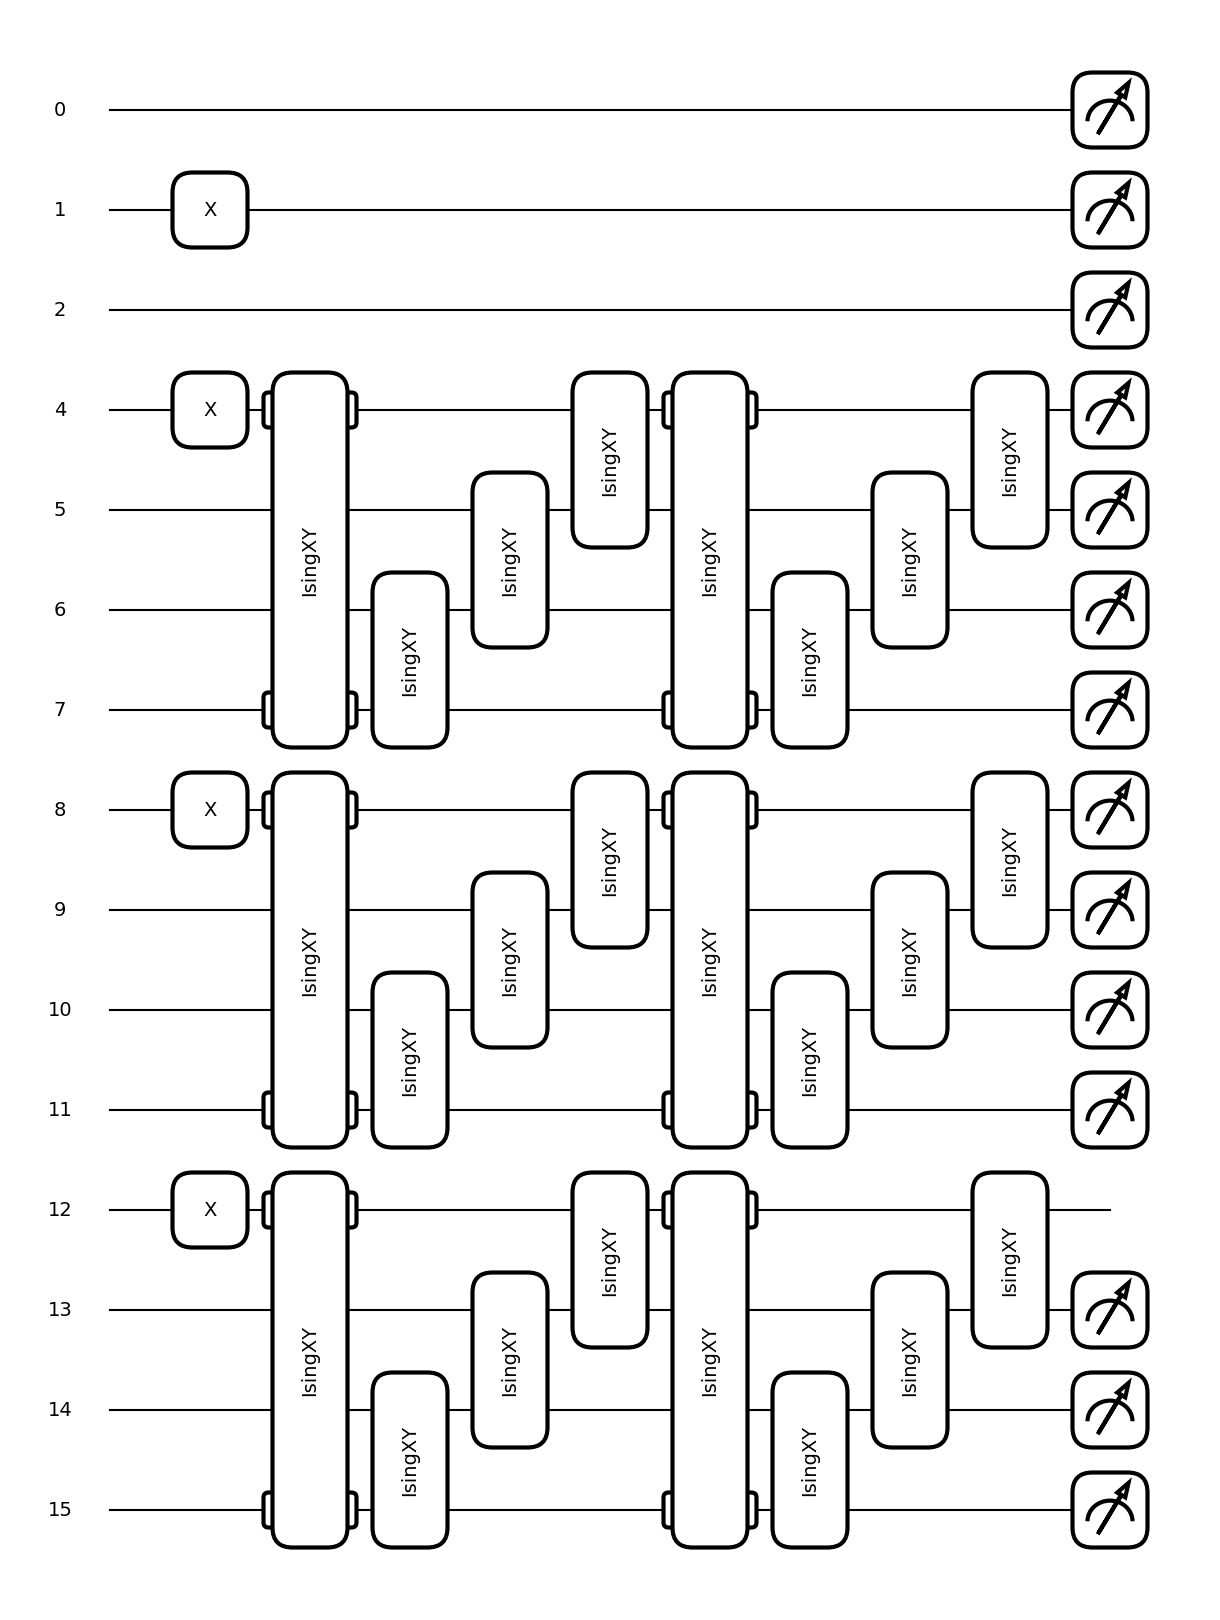

In [11]:
print(qml.draw_mpl(main_circuit)())

### Optimizing

In [ ]:
optimizer = optim.SGD([w],lr=0.05,momentum=1) #lr : learning rate, SGD : gradient descent
for iter in range(N_iter):
    #cost function
    cost = main_circuit(w,C1,num_of_layers)
    #Optimizing step
    optimizer.zero_grad() #gradient 초기화
    cost.backward() #gradient 계산
    optimizer.step() #함수 개선

/usr/local/lib/python3.10/dist-packages/pennylane/measurements/expval.py:72: UserWarning: Sum might not be hermitian.
  warnings.warn(f"{op.name} might not be hermitian.")


### Result check

In [14]:
expect_E = main_circuit(w,C1,num_of_layers).item()
state_f = state_vec()
ans=0
result = []
print("expectation value of energy : ",expect_E)

expectation value of energy :  0.7660528759833362


In [15]:
'''
for i in range(2 ** (board_size * board_size)):
    print(f"probability of getting |{i}> :",abs(state_f[i])**2)
'''
for i in range(2 ** (board_size * board_size)):
    if abs(state_f[i]) ** 2 > 0.1:
        result.append((bin(i)[2:], abs(state_f[i].item())**2))
        print(format(i,'b')+"is ground state with probability",abs(state_f[i].item())**2)


100001000010001is ground state with probability 0.2062962210384992
100001000011000is ground state with probability 0.6200044296810338


## Result Chk

In [16]:
result.sort(key = lambda x:x[1])
result = result [::-1]
print(result)

[('100001000011000', 0.6200044296810338), ('100001000010001', 0.2062962210384992)]


In [17]:
def answer(result : dict):
    n = C1.size
    for e in result:
      print('===========================')
      ans = int(e[0])
      coordinates = []
      cnt = n * n - 1
      while cnt >= 0:
        if ans % 10 == 1:
          coordinates.append([cnt // n, cnt % n])
        cnt -= 1
        ans //= 10
      tempC = Chess(n, coordinates)
      tempC.draw()
      print('===========================')

    '''
    for ans in result:
      temp_board  = [[0 for _ in range(n) for _ in range(n)]]
      cnt = n ** 2 - 1
      while cnt > 0:
        i, j = cnt // n, cnt % n
        temp_board[i][j] = ans % 10
        ans //= 10
        cnt -= 1
    '''
    return

answer(result)

□◆□□
□□◆□
□□□◆
◆□□□
□◆□□
□□◆□
□□□◆
□□□◆
